# Detecting Alerts and Trends for Narratives

Inputs: Dataset

Outputs: 
- List of dates with alerts
- For each date a summary explaining the alert

In [1]:
import os 
from os.path import join, dirname 


PATH_REPO = dirname(os.getcwd())
PATH_DATA = join(PATH_REPO, 'data')
PATH_UTILS = join(PATH_REPO, 'src')

import sys

sys.path.append(PATH_REPO)
#sys.path.append(PATH_UTILS)

from src import time_series
from src import utils_plot
from src import anomaly
from src import preprocess
from src import summarize
from src import top_terms_extractor
from src import top_trends
from src import preprocesser
import pandas as pd
import numpy as np

In [2]:
name_data =  'Diarrhea+Vomit test'#'Congo virus - Pakistan - Data (1)'
data = pd.read_csv(join(PATH_DATA, f'{name_data}.csv'))
#data['date'] = pd.to_datetime(data['date'])
data.head(5)

,id,text,created_at,lang,source,name,screen_name,bio,us_created_at,followers_count,friends_count,statuses_count,favourites_count,country,country_code,locality,region,sub_region,coordinates,date
0,1521032726001901570,@UhKBMxEiE3vRxJa الله وكيلك صابهم اسهال,2022-05-02T07:43:55+00:00,ar,twitter,al Mh,@mh89al89,أثق بي جداً انا صلب\nبما يكفي للتجاوز دائماً ..,2021-11-09T02:32:56+00:00,181,339,5566,9045,Iraq,IQ,NaN,NaN,NaN,"33.0, 44.0",2022-05-02
1,1520932713791905792,يارب قلبا ، سليما ، عفيفا ، تقيا ، نقيا ، يخشا...,2022-05-02T01:06:31+00:00,ar,twitter,N,@nahed_66x,skylover☁️.,2020-01-30T23:25:58+00:00,141,276,3536,12186,Iraq,IQ,Al Kūt,Wāsiţ,NaN,"32.5128, 45.81817",2022-05-02
2,1520864415922466817,@Falah_Almashal يمعود اصلا غلط الكيمير يوم الع...,2022-05-01T20:35:07+00:00,ar,twitter,Hasanain,@Hasanai04947563,Master in business engineering management / in...,2020-06-26T22:12:23+00:00,14,241,462,120,Iraq,IQ,NaN,NaN,NaN,"33.0, 44.0",2022-05-01
3,1520846958407077894,اللهُم قلبًا سليمًا عفيفًا تقيًا نقيًا يخشاك س...,2022-05-01T19:25:45+00:00,ar,twitter,عـَبّٰآْسِْٓ اَلًسَّبِْٓعٌَ 🇮🇶,@ab22220,إن في قلبي أُمنية .. وانت يا ربّي مُجيب,2013-01-13T16:17:59+00:00,2518,4675,273,5099,Iraq,IQ,NaN,NaN,NaN,"33.0, 44.0",2022-05-01
4,1520832348572553217,@emad_bajalan هاي مو من الصوم، ،، الصوم يزكي ا...,2022-05-01T18:27:42+00:00,ar,twitter,عمار اللامي,@ammarallami0388,‏العراق حر \n🇮🇶🇵🇸,2020-01-19T16:42:22+00:00,307,509,4915,14291,Iraq,IQ,NaN,NaN,NaN,"33.0, 44.0",2022-05-01


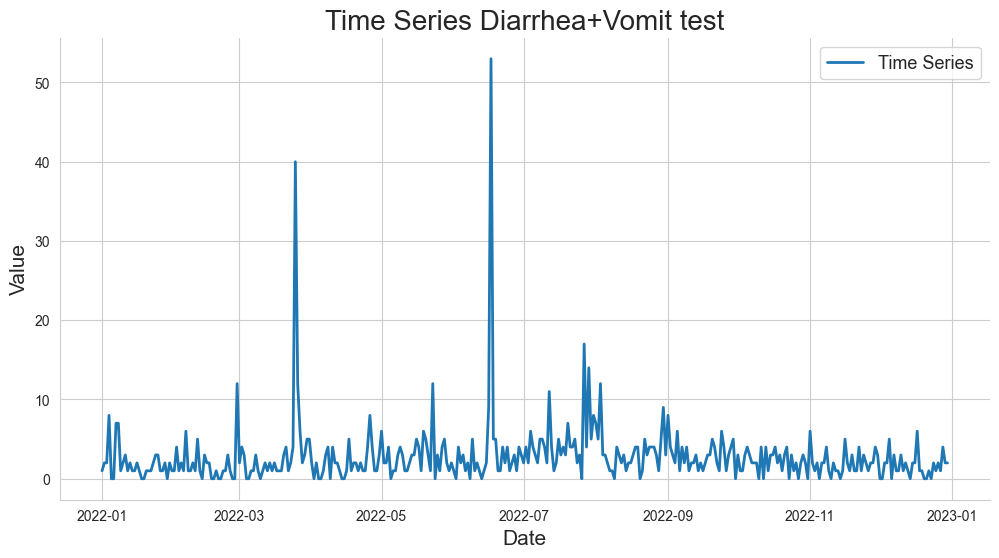

In [3]:
if 'date' not in data.columns:
    data['date'] = data['created_at'].apply(lambda x: x[:10])
data_count = preprocess.data2timeSeries(data)

ts = data_count.loc[:,'text'].values
dates = data_count.index
dates = pd.to_datetime(dates)

timeseries = time_series.timeSeries(ts, dates)
utils_plot.plot_time_series(timeseries, label=f'Time Series {name_data}')

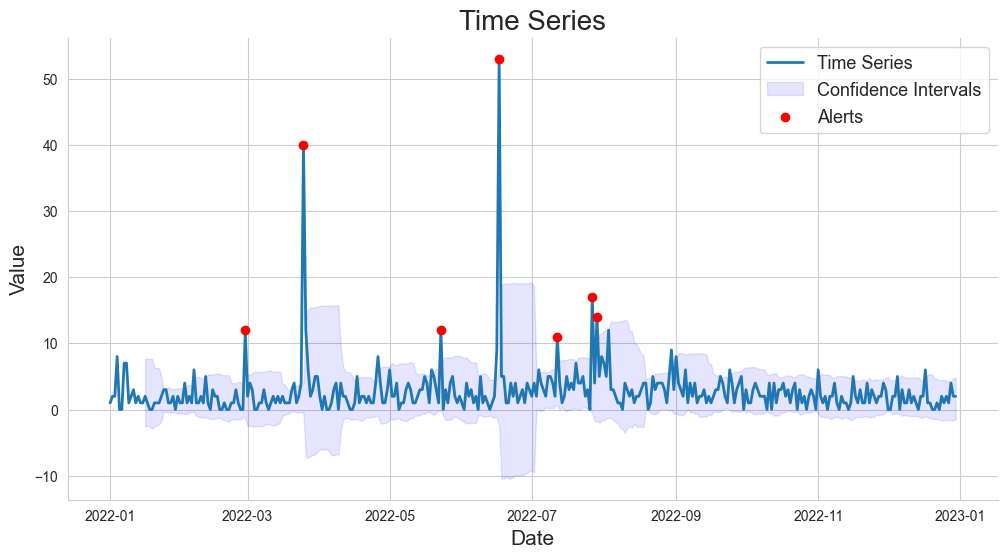

In [4]:
alerts_detector = anomaly.algorithmAnomalyTimeSeries(window = 15)
results = alerts_detector.detect_alerts(timeseries)
utils_plot.plot_time_series_alerts(timeseries, results['modified_time_series'], alerts=results['alerts'], prediction_intervals=True, window=20, label='Time Series')

In [37]:
dict_marc = {}
dict_marc['alerts_idx'] = results['alerts_idx']
dict_marc['time_series'] = results['original_time_series'].time_series.values
dict_marc['lower_bound'] = results['modified_time_series'].lower_bound.values
dict_marc['upper_bound'] = results['modified_time_series'].upper_bound.values

In [43]:
# put dict_marc in a .txt file
with open('dict_marc.txt', 'w') as file:
    for key, value in dict_marc.items():
        file.write(f'{key}: {value}\n')

In [42]:
import json
import pickle

# save dict marc into a pickle file
with open('dict_marc.pickle', 'wb') as handle:
    pickle.dump(dict_marc, handle, protocol=pickle.HIGHEST_PROTOCOL)

#with open('dict_marc.json', 'w') as fp:
#    json.dump(dict_marc, fp)

#dict_marc

In [5]:
import math
alerts_days = [day for day, value in zip(results['alerts'].index, results['alerts'].values) if not math.isnan(value)] 

day2text = {day:summarize.select_texts_per_day(data=data, day=day, text_column='text') for day in alerts_days}

# Narratives

### First: Extract trends

In [6]:
window_size = 15

for day, text in day2text.items():
    print(f'Toptrends for day {day}:')
    trends = top_trends.top_trends_tweets(summarize.select_window_texts(data= data, day_end= day, window=window_size), \
                                text, stop=None, rate=3)
    for term, freq in trends.items():
        print(f'trend: {term}, freq: {freq["freq_rate"]*100:.02f}%')
    print(f'\n -------------- \n ')

Toptrends for day 2022-06-21 00:00:00:
trend: پھیلنے کا, freq: 345.00%
trend: ایڈوائزری جاری, freq: 317.19%
trend: پر کانگو, freq: 595.31%
trend: وائرس پھیلنے, freq: 548.96%
trend: عیدالاضحی پر, freq: 456.25%
trend: کا تعلق, freq: 595.31%
trend: کا خطرہ, freq: 456.25%
trend: interrupt transmission, freq: 456.25%
trend: situation take, freq: 456.25%
trend: transmission congo, freq: 456.25%
trend: vigilant situation, freq: 456.25%
trend: آئی ایچ, freq: 734.38%
trend: آباد میڈیکل, freq: 1290.62%
trend: احتیاط کریں, freq: 456.25%
trend: انسانوں میں, freq: 1012.50%
trend: این آئی, freq: 734.38%
trend: ایچ نے, freq: 734.38%
trend: بھی کانگو, freq: 734.38%
trend: تدابیر اختیار, freq: 1012.50%
trend: حیات آباد, freq: 1290.62%
trend: سامنے گئے, freq: 456.25%
trend: صحت نے, freq: 1012.50%
trend: عید کے, freq: 1012.50%
trend: مریضوں میں, freq: 734.38%

 -------------- 
 
Toptrends for day 2022-06-29 00:00:00:


/Users/alejandrobonell/ds-Alerts/src/top_trends.py:126: RuntimeWarning: divide by zero encountered in double_scalars
  freq_rate = (top_terms.words_freqs_[word]-top_words_commons[word])/top_words_commons[word]


trend: ملتان, freq: inf%

 -------------- 
 
Toptrends for day 2022-07-07 00:00:00:
trend: بھی بچائیں, freq: 311.76%
trend: بھی بچیں, freq: 311.76%
trend: خود بھی, freq: 311.76%
trend: دوسروں کو, freq: 311.76%
trend: عید قرباں, freq: 311.76%
trend: قرباں پر, freq: 311.76%
trend: لئے احتیاطی, freq: 311.76%
trend: کو بھی, freq: 311.76%
trend: کے لئے, freq: 311.76%
trend: عیدالاضحی, freq: inf%

 -------------- 
 
Toptrends for day 2023-05-07 00:00:00:
trend: انتقال کرگیا, freq: 427.27%
trend: مبتلا مریض, freq: 339.39%
trend: مریض انتقال, freq: 427.27%
trend: میں مبتلا, freq: 427.27%
trend: وائرس میں, freq: 427.27%
trend: life threatening, freq: 427.27%
trend: کوئٹہ کانگو, freq: 427.27%
trend: 28 year, freq: 954.55%
trend: according health, freq: 427.27%
trend: case life, freq: 690.91%
trend: muhammad adil, freq: 690.91%
trend: old resident, freq: 690.91%
trend: sindh health, freq: 427.27%
trend: year first, freq: 427.27%
trend: year old, freq: 954.55%
trend: 4jva3kucod, freq: inf%

 -----

### Second: Extract docs

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=500, stop_words='english')
X = vectorizer.fit_transform(data.loc[:,'text'].values.tolist())

In [13]:
query_keywords = ['congovirus karachi', 'cangovirus']
day = '2023-05-08'

from scipy.sparse.linalg import norm
from sklearn.metrics.pairwise import cosine_similarity


def get_related_texts(reference_text, texts, embedding_model):
    try:
        reference_embedding = embedding_model.transform([reference_text])
        text_embeddings = embedding_model.transform(texts)
    except:
        reference_embedding = embedding_model.encode([reference_text])
        text_embeddings = embedding_model.encode(texts)
    # Let's calculate the cosine similarity

    cosine_similarity_scores = cosine_similarity(reference_embedding, text_embeddings)[0]
    #cosine_similarity_scores =  np.array([1 - cosine(reference_embedding, row) for row in text_embeddings])

    # Let's sort the scores
    sorted_scores = np.argsort(cosine_similarity_scores)[::-1]

    # Let's get the top 5 related texts
    top_related_texts = [texts[i] for i in sorted_scores[:10]]

    return top_related_texts

texts = summarize.select_texts_per_day(data, day)
related_docs = get_related_texts(' '.join(query_keywords), texts, vectorizer)


### Third: Summarization

In [15]:
import openai
openai.api_key = api_key

summarize.generate_summarizer(related_docs)

'The Congo virus has made its first appearance in Karachi, Pakistan, with the report of a confirmed case. This has caused panic in the country after two deaths related to the virus were reported in Karachi and Quetta. Health authorities have been alerted and are taking necessary measures to address the situation. The news of these deaths has raised alarm among the public, leading to increased awareness about the Congo virus and its potential health risks. The Ministry of Health Pakistan is closely monitoring the situation and working to prevent further spread'